We plot the histograms of the eigenvalues

In [ ]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)
# delta_scale = "linear"
delta_scale = "log-scale"


folder_paths = {
    100: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval/{input_type}/',
    500: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N500/{input_type}/',
    # 1000: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N1000/{input_type}/'
}

In [ ]:
# %% Define a function to load data from a folder
def load_data(folder_path):
    # This dictionary will map each tensor name (file name without .pt)
    # to a dictionary that maps deltaval values to the loaded tensor.
    all_data = {}
    # The regular expression below finds folders that contain the right mu and delta_scale,
    # and extracts the delta value.
    pattern = re.compile(
        r'^(?=.*_mu_{})'
        r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(delta_scale))
    )
    representative_subfolder = None

    # Loop over all items in the main folder
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            match = pattern.search(subfolder)
            if match:
                representative_subfolder = subfolder
                # Convert the captured delta string to a float
                deltaval = float(match.group(1))
                
                # Loop over each file in the subfolder
                for filename in os.listdir(subfolder_path):
                    if filename.endswith('.pt'):
                        tensor_name = os.path.splitext(filename)[0]
                        tensor = torch.load(os.path.join(subfolder_path, filename))
                        if tensor_name not in all_data:
                            all_data[tensor_name] = {}
                        all_data[tensor_name][deltaval] = tensor

    # Load parameters from a representative subfolder
    param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
    with open(param_file_path, 'r') as f:
        params = json.load(f)
    
    # For example, we are interested in the eigenvalue data.
    eigvals_dict = all_data['eigvals_J']
    return eigvals_dict, params

# %% Load data for each N into a new dictionary.
data_by_N = {}
for N_val, folder_path in folder_paths.items():
    eigvals_dict, params = load_data(folder_path)
    data_by_N[N_val] = {
         'eigvals_dict': eigvals_dict,
         'params': params
    }

# %% Build a set of all delta values available across different N folders.
all_delta_vals = set()
for data in data_by_N.values():
    all_delta_vals.update(data['eigvals_dict'].keys())
all_delta_vals = sorted(all_delta_vals)


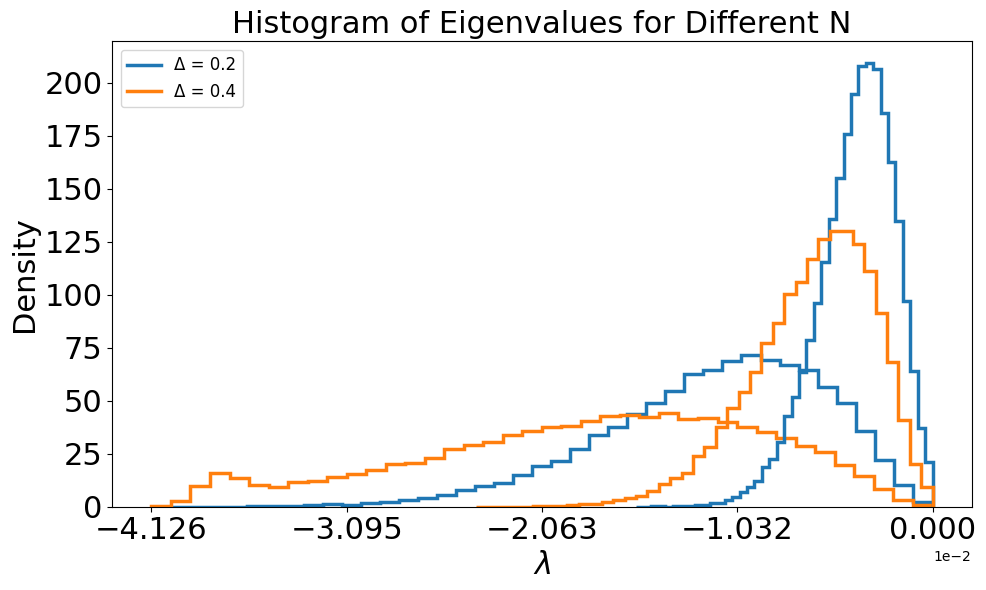

In [37]:
# Create a color mapping so that the same delta always gets the same color.
colors = plt.get_cmap("tab10")

# delta_vals = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
delta_vals = [0.2, 0.4]

# %% Plot the eigenvalue histograms for each N on the same axes.
plt.figure(figsize=(10, 6))
global_min = float('inf')
global_max = float('-inf')

# Loop over each N and then each delta value in that dataset.
for N_val, data in data_by_N.items():
    eigvals_dict = data['eigvals_dict']
    for i, delta_val in enumerate(delta_vals):
        eigvals = eigvals_dict[delta_val]
        # Compute the max real parts scaled by 0.002
        max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
        
        # Choose a specific z index (here z_idx = 0) and the first trial
        z_idx = 0
        max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
        # Keep only non-positive values
        max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
        # Convert tensor to numpy array
        data_arr = max_real_each_trial_input.cpu().numpy()
        
        # Update global x-axis limits for consistent ticks later.
        global_min = min(global_min, data_arr.min())
        global_max = max(global_max, data_arr.max())
        
        # Plot a line histogram using a consistent color for the given delta.
        plt.hist(data_arr, bins=40, density=True, histtype='step', linewidth=2.5,
                 color=colors(i), label=f"N = {N_val}, Δ = {delta_val}")

# Set labels, title, and ticks
plt.xlabel(r"$\lambda$", fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.title("Histogram of Eigenvalues for Different N", fontsize=22)
ticks = np.linspace(global_min, 0, 5)
ticks = np.sort(np.unique(np.concatenate((ticks, [0]))))
plt.xticks(ticks, fontsize=22)
plt.yticks(fontsize=22)
ax = plt.gca()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

# Build a custom legend that groups by delta (so the color coding is clear)
legend_elements = []
for i, delta_val in enumerate(delta_vals):
    legend_elements.append(Line2D([0], [0], color=colors(i), lw=2.5, label=f"Δ = {delta_val}"))
plt.legend(handles=legend_elements, fontsize=12)

# plt.yscale('log')
# plt.ylim(1, 1e3)

plt.tight_layout()
plt.show()


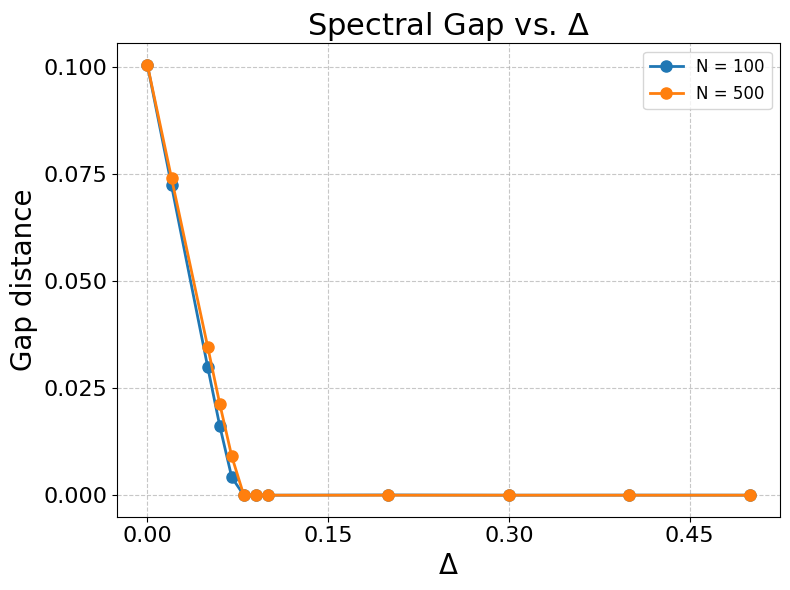

In [13]:

# %% (Optional) Plot the gap distance vs. Δ for each N on the same axes.
plt.figure(figsize=(8,6))
for N_val, data in data_by_N.items():
    eigvals_dict = data['eigvals_dict']
    delta_vals_sorted = sorted(eigvals_dict.keys())
    gapped_distances = []
    for delta_val in delta_vals_sorted:
        eigvals = eigvals_dict[delta_val]
        max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
        z_idx = 0
        max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
        max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
        data_arr = max_real_each_trial_input.cpu().numpy()
        gapped_distances.append(np.abs(data_arr.max()))
    
    # Plot with a distinct line for each N but reusing the same color mapping for each Δ.
    # Here we use markers for the gap distances for each N.
    plt.plot(delta_vals_sorted, gapped_distances, marker='o', markersize=8, linewidth=2,
             label=f"N = {N_val}")

plt.xlabel(r'$\Delta$', fontsize=20)
plt.ylabel('Gap distance', fontsize=20)
plt.title('Spectral Gap vs. $\Delta$', fontsize=22)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()